In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

6.269680512184071 -5.377219420363566


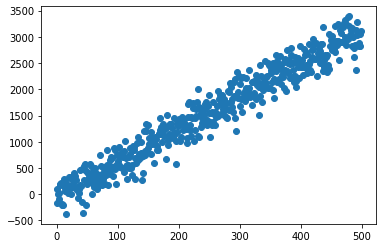

In [2]:
max_x = 500
slope_range = [.1, 10]
slope_direction = np.random.choice([-1,1])
intercept_range = [-40, 40]
residual_var = 100
X = torch.from_numpy(np.arange(max_x))
X = X.type(torch.float64)
m = np.random.uniform(*slope_range) * slope_direction
b = np.random.uniform(*intercept_range)
y = m * X + b + np.random.normal(0, residual_var, len(X)) * m/3
print(m, b)
plt.scatter(X, y)

In [3]:
class Model:
    def __init__(self, params):
        self.parameters = params # weights for slope and bias (could have been stored outside of model)
        self.y_pred = None # Will hold last prediction when training loop is done
    def set_learning_objects(self, criterion, optimizer):
        self.criterion = criterion
        self.optimizer = optimizer
    def train(self, X):
        return self.parameters[0][0] * X + self.parameters[0][1] # Just a simple line eq. with current m and b weights
    def training_loop(self, epochs, X, y):
        for epoch in [e+1 for e in range(epochs)]: # Make ephochs 1 based
            self.y_pred = self.train(X) # No batching here, we run all data and adjust the weights after the run
            loss = self.criterion(self.y_pred, y) # What ever loss function that was passed is used
            self.optimizer.zero_grad() # Gradients sum with each back prop, so we need to manually zero out the last derivatives
            loss.backward() # The acutal back proagation
            self.optimizer.step() # Updates the weights (self.parameters)
            if epoch % 10 == 0 or epoch == np.max(range(epochs)):
                print("Epoch: {} - Loss: {}".format(epoch, float(loss)))

In [4]:
weights = np.random.normal(.7, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
weights

0.7097358637674752

In [5]:
bias = np.random.normal(0, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
bias

0.002563594348438489

In [6]:
#weights are a enumerable tensor.  In our simple r1 maps to r1, it is just 2 trainable paramaters
weights_bias = torch.tensor([weights, bias], requires_grad=True) # requires_grad=True maintains the state for the back prop

In [7]:
#custom optimizer, just plain old Gradiant Decent with a learning rate
class GD_Optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(GD_Optimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(-group['lr'], d_p)

        return loss            

In [8]:
model = Model([weights_bias])

#hyper-parameters
epochs = 500
learning_rate = 1e-5

#loss
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.L1Loss()
# criterion = lambda y, y_pred : torch.mean((y - y_pred)**2)
criterion = lambda y, y_pred : torch.mean(abs(y - y_pred))

# back prop gradient decent optimizer
# optimizer = optim.SGD(model.parameters, lr=learning_rate)
# optimizer = optim.SGD(model.parameters, lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters)
optimizer = MyOptimizer(model.parameters)


model.set_learning_objects(criterion, optimizer)

In [9]:
y_pred = model.train(X)
model.parameters
#This is just a made up linear plot with random slope and intercept since no parameter training was done
# plt.scatter(y, y_pred) 

[tensor([0.7097, 0.0026], requires_grad=True)]

In [10]:
criterion(y, y_pred)

tensor(1382.3882, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [11]:
model.training_loop(epochs, X, y)

Epoch: 10 - Loss: 833.9703328740973
Epoch: 20 - Loss: 285.955260502859
Epoch: 30 - Loss: 169.92576208779386
Epoch: 40 - Loss: 169.9204013225739
Epoch: 50 - Loss: 169.91997222037043
Epoch: 60 - Loss: 169.9196741518681
Epoch: 70 - Loss: 169.92031528417195
Epoch: 80 - Loss: 169.9198162025305
Epoch: 90 - Loss: 169.9199048385327
Epoch: 100 - Loss: 169.92015926633204
Epoch: 110 - Loss: 169.9196601846906
Epoch: 120 - Loss: 169.92013552519725
Epoch: 130 - Loss: 169.92000324849215
Epoch: 140 - Loss: 169.91950416685071
Epoch: 150 - Loss: 169.92034631229367
Epoch: 160 - Loss: 169.91984723065224
Epoch: 170 - Loss: 169.91963904115605
Epoch: 180 - Loss: 169.92019029445376
Epoch: 190 - Loss: 169.91969121281232
Epoch: 200 - Loss: 169.9198697278206
Epoch: 210 - Loss: 169.92003427661385
Epoch: 220 - Loss: 169.9195351949724
Epoch: 230 - Loss: 169.9201004144852
Epoch: 240 - Loss: 169.91987825872178
Epoch: 250 - Loss: 169.91937917689782
Epoch: 260 - Loss: 169.92022132218432
Epoch: 270 - Loss: 169.919722240

In [12]:
model.parameters
pred_slope = model.parameters[0][0].item()
pred_intercept = model.parameters[0][1].item()
print ("Actual Slope: {}  Actual Intercept: {}".format(m, b))
print ("Model Slope: {}  Model Intercept: {}".format(pred_slope, pred_intercept))

Actual Slope: 6.269680512184071  Actual Intercept: -5.377219420363566
Model Slope: 6.214981555938721  Model Intercept: 0.007855619303882122


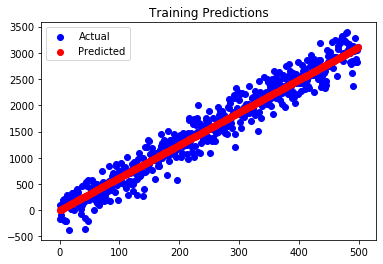

In [13]:
plt.scatter(X, y, color='b', label='Actual')
plt.scatter(X, model.y_pred.detach().numpy(), color='r', label='Predicted')
plt.title('Training Predictions')
plt.legend()
plt.show()